# iQuHack 2026 - Quantum Entanglement Distillation Game

In this game, you design quantum circuits to distill noisy Bell pairs and claim edges in a network.

**Game Flow**: Register -> Select Starting Node -> Design Circuits -> Claim Edges -> Score Points

In [1]:
from client import GameClient
from visualization import GraphTool
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.classical import expr
import json
from pathlib import Path
import numpy as np

## Session Management

Save/load your session to avoid re-registering.

In [2]:
SESSION_FILE = Path("session.json")

def save_session(client):
    if client.api_token:
        with open(SESSION_FILE, "w") as f:
            json.dump({"api_token": client.api_token, "player_id": client.player_id, "name": client.name}, f)
        print(f"Session saved.")

def load_session():
    if not SESSION_FILE.exists():
        return None
    with open(SESSION_FILE) as f:
        data = json.load(f)
    client = GameClient(api_token=data.get("api_token"))
    client.player_id = data.get("player_id")
    client.name = data.get("name")
    status = client.get_status()
    if status:
        print(f"Resumed: {client.player_id} | Score: {status.get('score', 0)} | Budget: {status.get('budget', 0)}")
        return client
    return None

# {"api_token": "Sr6McJUsTTpS7GW8eoAqahJbU34itIT2iY7W37RzFPY", "player_id": "superteto", "name": "K. Teto"}

In [3]:
# Try to resume existing session
client = load_session()

if not client:
    print("No saved session. Register below.")

No saved session. Register below.


## Step 1: Register

Skip this if you resumed a session above.

In [5]:
if client and client.api_token:
    print(f"Already registered as {client.player_id}")
else:
    client = GameClient()
    
    # CHANGE THESE to your unique values
    PLAYER_ID = "hyperteto"
    PLAYER_NAME = "hyperteto"
    
    result = client.register(PLAYER_ID, PLAYER_NAME, location=input("remote or in_person: ").strip())
    
    if result.get("ok"):
        print(f"Registered! Token: {client.api_token[:20]}...")
        candidates = result["data"].get("starting_candidates", [])
        print(f"\nStarting candidates ({len(candidates)}):")
        for c in candidates:
            print(f"  - {c['node_id']}: {c['utility_qubits']} qubits, +{c['bonus_bell_pairs']} bonus")
        save_session(client)
    else:
        print(f"Failed: {result.get('error', {}).get('message')}")

remote or in_person:  in_person


Registered! Token: C_xeo5h6bO_8hBNlziaO...

Starting candidates (4):
  - Blacksburg, VA: 1 qubits, +0 bonus
  - Richmond, VA: 2 qubits, +0 bonus
  - Cincinnati, OH: 3 qubits, +0 bonus
  - Guadalajara, Mexico: 4 qubits, +0 bonus
Session saved.


## Step 2: Select Starting Node

In [93]:
status = client.get_status()

if status.get('starting_node'):
    print(f"Starting node: {status['starting_node']}")
    print(f"Budget: {status['budget']} | Score: {status['score']}")
else:
    print("Select a starting node from the candidates shown above.")
    # Uncomment and modify:
    result = client.select_starting_node("Cambridge, MA")
    print(result)

Select a starting node from the candidates shown above.
{'ok': True, 'data': {'success': True, 'starting_node': 'Cambridge, MA', 'score': 0, 'budget': 40}}


## Step 3: Explore the Network

In [94]:
client.print_status()

Player: superteto (K. Teto)
Score: 0 | Budget: 40 bell pairs
Active: Yes
Starting node: Cambridge, MA
Owned: 1 nodes, 0 edges
Claimable edges: 6
  - ['Boston, MA', 'Cambridge, MA']: threshold=0.90, difficulty=1
  - ['Cambridge, MA', 'Halifax, Canada']: threshold=0.90, difficulty=3
  - ['Cambridge, MA', 'Providence, RI']: threshold=0.90, difficulty=1
  ... and 3 more


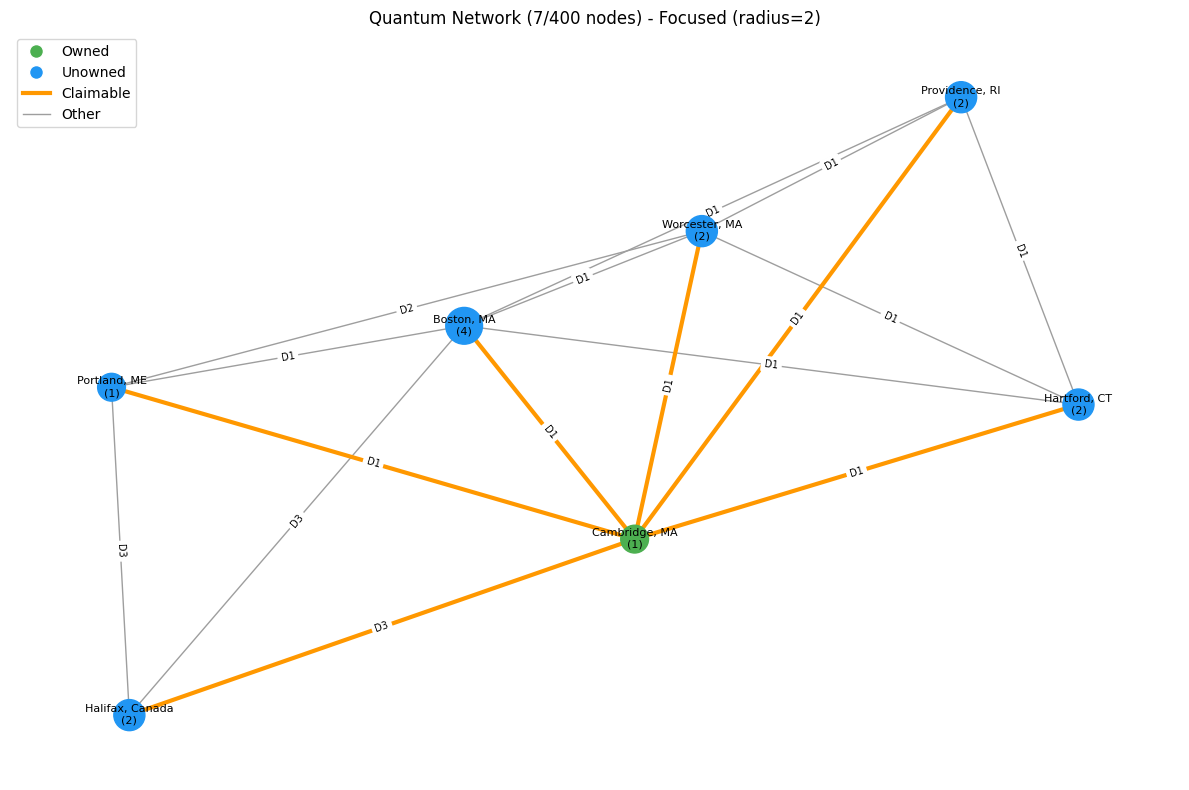

In [95]:
# Visualize the network (focused around your nodes)
viz = GraphTool(client.get_cached_graph())
owned = set(client.get_status().get('owned_nodes', []))
viz.render(owned)

## Step 4: Design a Distillation Circuit

For N Bell pairs, qubits are paired outside-in:
- Pair 0: qubits {0, 2N-1}
- Pair 1: qubits {1, 2N-2}
- ...
- Final pair: qubits {N-1, N}

Design a circuit that improves fidelity through LOCC operations.

In [209]:
def create_distillation_circuit():
    """Example distillation circuit template for 2 Bell pairs."""
    qr = QuantumRegister(4, 'q')  # 4 qubits for 2 Bell pairs
    cr = ClassicalRegister(3, 'c')  # Classical bits for measurements + flag
    qc = QuantumCircuit(qr, cr)
    
    # TODO: Add your distillation operations here
    # Qubit layout for N=2:
    #   q0, q3: Ancilla pair (to be measured)
    #   q1, q2: Data pair (output)

    qc.rx(-np.pi / 2, qr[0])
    qc.rx(-np.pi / 2, qr[1])
    qc.rx(np.pi / 2, qr[2])
    qc.rx(np.pi / 2, qr[3])

    qc.cx(qr[1], qr[0])
    qc.cx(qr[2], qr[3])

    qc.measure(qr[0], cr[1])
    qc.measure(qr[3], cr[2])
    qc.store(cr[0], expr.bit_xor(cr[1], cr[2]))

    
    return qc

circuit = create_distillation_circuit()
print(circuit.draw(output='text'))

     ┌──────────┐┌───┐┌─┐   
q_0: ┤ Rx(-π/2) ├┤ X ├┤M├───
     ├──────────┤└─┬─┘└╥┘   
q_1: ┤ Rx(-π/2) ├──■───╫────
     ├─────────┬┘      ║    
q_2: ┤ Rx(π/2) ├───■───╫────
     ├─────────┤ ┌─┴─┐ ║ ┌─┐
q_3: ┤ Rx(π/2) ├─┤ X ├─╫─┤M├
     └─────────┘ └───┘ ║ └╥┘
c: 3/══════════════════╩══╩═
                       1  2 


In [210]:
'''def create_level_n_pyramid():
    """Example distillation circuit template for 3 Bell pairs."""
    n = 2
    N = 2 ** n
    target_a = N - 1
    target_b = N
    qr = QuantumRegister(N * 2, 'q')  
    cr = ClassicalRegister(7, 'c')  # Classical bits for measurements + flag
    qc = QuantumCircuit(qr, cr)
    
    # Qubit layout for N=3:
    #   q0, q5: Ancilla pair
    #   q1, q4: Ancilla pair
    #   q2, q3: Data pair
    for i in range(4):
        qc.rx(np.pi / 2, qr[i])
        qc.rx(-np.pi / 2, qr[i+4])

    for i in range(n):
        for j in range(2 ** (n - i - 1)):
            qc.cx(qr[j + 1], qr[j])
            qc.cx(qr[N - j - 2], qr[N - j - 1])
            qc.measure(qr[j], cr[j])
            qc.measure(qr[N - j - 1], cr[2])


    qc.cx(qr[1], qr[0])
    qc.cx(qr[6], qr[7])
    qc.cx(qr[3], qr[2])
    qc.cx(qr[4], qr[5])

    qc.measure(qr[0], cr[1])
    qc.measure(qr[7], cr[2])
    qc.measure(qr[2], cr[3])
    qc.measure(qr[5], cr[4])

    qc.cx(qr[3], qr[1])
    qc.cx(qr[4], qr[6])

    qc.measure(qr[1], cr[5])
    qc.measure(qr[6], cr[6])

    qc.store(cr[1], expr.bit_xor(cr[1], cr[2]))
    qc.store(cr[3], expr.bit_xor(cr[3], cr[4]))
    qc.store(cr[5], expr.bit_xor(cr[5], cr[6]))
    qc.store(cr[2], expr.bit_or(cr[1], cr[3]))
    qc.store(cr[0], expr.bit_or(cr[2], cr[5]))
    # qc.store(cr[0], expr.bit_not(cr[0]))

    return qc

circuit = create_level_n_pyramid()
print(circuit.draw(output='text'))'''

'def create_level_n_pyramid():\n    """Example distillation circuit template for 3 Bell pairs."""\n    n = 2\n    N = 2 ** n\n    target_a = N - 1\n    target_b = N\n    qr = QuantumRegister(N * 2, \'q\')  \n    cr = ClassicalRegister(7, \'c\')  # Classical bits for measurements + flag\n    qc = QuantumCircuit(qr, cr)\n\n    # Qubit layout for N=3:\n    #   q0, q5: Ancilla pair\n    #   q1, q4: Ancilla pair\n    #   q2, q3: Data pair\n    for i in range(4):\n        qc.rx(np.pi / 2, qr[i])\n        qc.rx(-np.pi / 2, qr[i+4])\n\n    for i in range(n):\n        for j in range(2 ** (n - i - 1)):\n            qc.cx(qr[j + 1], qr[j])\n            qc.cx(qr[N - j - 2], qr[N - j - 1])\n            qc.measure(qr[j], cr[j])\n            qc.measure(qr[N - j - 1], cr[2])\n\n\n    qc.cx(qr[1], qr[0])\n    qc.cx(qr[6], qr[7])\n    qc.cx(qr[3], qr[2])\n    qc.cx(qr[4], qr[5])\n\n    qc.measure(qr[0], cr[1])\n    qc.measure(qr[7], cr[2])\n    qc.measure(qr[2], cr[3])\n    qc.measure(qr[5], cr[4])\n\n 

In [6]:
def create_level_n_ladder(N):
    """Example distillation circuit template for N Bell pairs."""
    #N = 7
    target_a = N - 1
    target_b = N
    qr = QuantumRegister(N * 2, 'q')  
    cr = ClassicalRegister(N * 2 - 1, 'c')  # Classical bits for measurements + flag
    qc = QuantumCircuit(qr, cr)
    
    # Qubit layout for N=3:
    #   q0, q5: Ancilla pair
    #   q1, q4: Ancilla pair
    #   q2, q3: Data pair
    '''for i in range(N):
        qc.rx(np.pi / 2, qr[i])
        qc.rx(-np.pi / 2, qr[2 * N - 1 - i])'''
    qc.rx(np.pi / 2, qr[target_a])
    qc.rx(-np.pi / 2, qr[target_b])

    for i in range(N - 1):
        # rotation
        qc.rx(np.pi / 2, qr[i])
        qc.rx(-np.pi / 2, qr[2 * N - 1 - i])   
            
        qc.cx(qr[target_a], qr[i])
        qc.cx(qr[target_b], qr[2 * N - 1 - i])
    
        qc.measure(qr[i], cr[i * 2 + 1])
        qc.measure(qr[2 * N - 1 - i], cr[i * 2 + 2])

        #    qc.rx(-np.pi / 2, qr[target_a])
        #    qc.rx(np.pi / 2, qr[target_b])
    
        qc.barrier()

    for i in range(N - 1):
        qc.store(cr[i * 2 + 1], expr.bit_xor(cr[i * 2 + 1], cr[i * 2 + 2]))
        qc.store(cr[0], expr.bit_or(cr[0], cr[i * 2 + 1]))
        # qc.store(cr[0], expr.bit_not(cr[0]))

    return qc

circuit = create_level_n_ladder(3)
print(circuit.draw(output='text'))

     ┌─────────┐ ┌───┐┌─┐    ░                         ░ 
q_0: ┤ Rx(π/2) ├─┤ X ├┤M├────░─────────────────────────░─
     └─────────┘ └─┬─┘└╥┘    ░ ┌─────────┐ ┌───┐┌─┐    ░ 
q_1: ──────────────┼───╫─────░─┤ Rx(π/2) ├─┤ X ├┤M├────░─
     ┌─────────┐   │   ║     ░ └─────────┘ └─┬─┘└╥┘    ░ 
q_2: ┤ Rx(π/2) ├───■───╫─────░───────────────■───╫─────░─
     ├─────────┴┐      ║     ░                   ║     ░ 
q_3: ┤ Rx(-π/2) ├──■───╫─────░───────────────■───╫─────░─
     └──────────┘  │   ║     ░ ┌──────────┐┌─┴─┐ ║ ┌─┐ ░ 
q_4: ──────────────┼───╫─────░─┤ Rx(-π/2) ├┤ X ├─╫─┤M├─░─
     ┌──────────┐┌─┴─┐ ║ ┌─┐ ░ └──────────┘└───┘ ║ └╥┘ ░ 
q_5: ┤ Rx(-π/2) ├┤ X ├─╫─┤M├─░───────────────────╫──╫──░─
     └──────────┘└───┘ ║ └╥┘ ░                   ║  ║  ░ 
c: 5/══════════════════╩══╩══════════════════════╩══╩════
                       1  2                      3  4    


In [146]:
def create_level_n_custom(N, H, S, Rz):
    """Example distillation circuit template for N Bell pairs."""
    target_a = N - 1
    target_b = N
    qr = QuantumRegister(N * 2, 'q')  
    cr = ClassicalRegister(N * 2 - 1, 'c')  # Classical bits for measurements + flag
    qc = QuantumCircuit(qr, cr)
    
    # Qubit layout for N=3:
    #   q0, q5: Ancilla pair
    #   q1, q4: Ancilla pair
    #   q2, q3: Data pair
    '''for i in range(N):
        qc.rx(np.pi / 2, qr[i])
        qc.rx(-np.pi / 2, qr[2 * N - 1 - i])'''
    
    th = np.pi / 2

    for i in range(N - 1):
        if i in H:
            qc.h(qr[i])
            qc.h(qr[2 * N - 1 - i])
        elif i in S:
            qc.sdg(qr[i])
            qc.sdg(qr[2 * N - 1 - i])
            qc.h(qr[i])
            qc.h(qr[2 * N - 1 - i])
        elif i in Rz: 
            pass
            #qc.rz(th, qr[i])
            #qc.rz(-th, qr[2 * N - 1 - i])
        else:
            qc.rx(th, qr[i])
            qc.rx(-th, qr[2 * N - 1 - i])

        if i in H: 
            qc.h(qr[target_a])
            qc.h(qr[target_b])
        elif i in S:
            qc.sdg(qr[target_a])
            qc.sdg(qr[target_b])
            qc.h(qr[target_a])
            qc.h(qr[target_b])
        elif i in Rz:
            pass
            #qc.rz(th, qr[target_a])
            #qc.rz(-th, qr[target_b])
        else:
            qc.rx(th, qr[target_a])
            qc.rx(-th, qr[target_b])
                    
            
        qc.cx(qr[target_a], qr[i])
        qc.cx(qr[target_b], qr[2 * N - 1 - i])
    
        qc.measure(qr[i], cr[i * 2 + 1])
        qc.measure(qr[2 * N - 1 - i], cr[i * 2 + 2])

        if i in H: 
            qc.h(qr[target_a])
            qc.h(qr[target_b])
        elif i in S:
            qc.h(qr[target_a])
            qc.h(qr[target_b])
            qc.s(qr[target_a])
            qc.s(qr[target_b])
        elif i in Rz:
            pass
            #qc.rz(-th, qr[target_a])
            #qc.rz(th, qr[target_b])
        else:
            qc.rx(-th, qr[target_a])
            qc.rx(th, qr[target_b])

        #else:
        #    qc.rx(-np.pi / 2, qr[target_a])
        #    qc.rx(np.pi / 2, qr[target_b])
            
        qc.barrier()

    for i in range(N - 1):
        qc.store(cr[i * 2 + 1], expr.bit_xor(cr[i * 2 + 1], cr[i * 2 + 2]))
        qc.store(cr[0], expr.bit_or(cr[0], cr[i * 2 + 1]))
        # qc.store(cr[0], expr.bit_not(cr[0]))

    return qc

circuit = create_level_n_custom(8, [1,2], [], [0,3])
print(circuit.draw(output='text'))

      ┌───┐┌─┐    ░                    ░                    ░             ░ »
 q_0: ┤ X ├┤M├────░────────────────────░────────────────────░─────────────░─»
      └─┬─┘└╥┘    ░ ┌───┐┌───┐┌─┐      ░                    ░             ░ »
 q_1: ──┼───╫─────░─┤ H ├┤ X ├┤M├──────░────────────────────░─────────────░─»
        │   ║     ░ └───┘└─┬─┘└╥┘      ░ ┌───┐┌───┐┌─┐      ░             ░ »
 q_2: ──┼───╫─────░────────┼───╫───────░─┤ H ├┤ X ├┤M├──────░─────────────░─»
        │   ║     ░        │   ║       ░ └───┘└─┬─┘└╥┘      ░ ┌───┐┌─┐    ░ »
 q_3: ──┼───╫─────░────────┼───╫───────░────────┼───╫───────░─┤ X ├┤M├────░─»
        │   ║     ░        │   ║       ░        │   ║       ░ └─┬─┘└╥┘    ░ »
 q_4: ──┼───╫─────░────────┼───╫───────░────────┼───╫───────░───┼───╫─────░─»
        │   ║     ░        │   ║       ░        │   ║       ░   │   ║     ░ »
 q_5: ──┼───╫─────░────────┼───╫───────░────────┼───╫───────░───┼───╫─────░─»
        │   ║     ░        │   ║       ░        │   ║       ░   

In [143]:
# Find claimable edges
claimable = client.get_claimable_edges()
claimable_sorted = sorted(claimable, key=lambda e: (e['difficulty_rating'], e['base_threshold']))

print(f"Claimable edges ({len(claimable)}):")
for edge in claimable_sorted[:30]:
    print(f"  {edge['edge_id']} - threshold: {edge['base_threshold']:.3f}, difficulty: {edge['difficulty_rating']}")

Claimable edges (24):
  ['Oxford, UK', 'Southampton, UK'] - threshold: 0.900, difficulty: 1
  ['London, UK', 'Southampton, UK'] - threshold: 0.900, difficulty: 1
  ['Belfast, UK', 'Dublin, Ireland'] - threshold: 0.900, difficulty: 1
  ['Hartford, CT', 'New Haven, CT'] - threshold: 0.900, difficulty: 1
  ['New Haven, CT', 'Providence, RI'] - threshold: 0.900, difficulty: 1
  ['New Haven, CT', 'Worcester, MA'] - threshold: 0.900, difficulty: 1
  ['Bristol, UK', 'Southampton, UK'] - threshold: 0.900, difficulty: 1
  ['Albany, NY', 'Hartford, CT'] - threshold: 0.900, difficulty: 1
  ['Boston, MA', 'Portland, ME'] - threshold: 0.900, difficulty: 1
  ['Cambridge, MA', 'Portland, ME'] - threshold: 0.900, difficulty: 1
  ['Cardiff, UK', 'Southampton, UK'] - threshold: 0.900, difficulty: 1
  ['Dublin, Ireland', 'Galway, Ireland'] - threshold: 0.900, difficulty: 2
  ['Dublin, Ireland', 'Liverpool, UK'] - threshold: 0.900, difficulty: 2
  ['Cork, Ireland', 'Dublin, Ireland'] - threshold: 0.900, d

In [142]:
# Claim an edge
if claimable:
    target = claimable_sorted[0]  # Easiest edge
    edge_id = tuple(target['edge_id'])

    
    num_bell_pairs = 2
    circuit = create_level_n_ladder(num_bell_pairs)
    #circuit = create_level_n_custom(num_bell_pairs, [], [], [2])
    flag_bit = 0  # Classical bit for post-selection (keep when flag=0)
    
    print(f"Claiming {edge_id} (threshold: {target['base_threshold']:.3f})...")
    
    result = client.claim_edge(edge_id, circuit, flag_bit, num_bell_pairs)
    
    if result.get("ok"):
        data = result["data"]
        print(f"Success: {data.get('success')}")
        print(f"Fidelity: {data.get('fidelity', 0):.4f} (threshold: {data.get('threshold', 0):.4f})")
        print(f"Success probability: {data.get('success_probability', 0):.4f}")
    else:
        print(f"Error: {result.get('error', {}).get('message')}")

Claiming ('Cambridge, MA', 'Hartford, CT') (threshold: 0.900)...
Success: True
Fidelity: 0.9698 (threshold: 0.9000)
Success probability: 0.7450


## Step 5: Claim an Edge

In [230]:
budget = 75

while budget > 0:
    
    # Find claimable edges
    claimable = client.get_claimable_edges()
    claimable_sorted = sorted(claimable, key=lambda e: (e['difficulty_rating'], e['base_threshold']))
    
    print(f"Claimable edges ({len(claimable)}):")
    for edge in claimable_sorted[:20]:
        print(f"  {edge['edge_id']} - threshold: {edge['base_threshold']:.3f}, difficulty: {edge['difficulty_rating']}")
    
    # Claim an edge
    if claimable:
        target = claimable_sorted[0]  # Easiest edge
        edge_id = tuple(target['edge_id'])

        for n in range(2, 9):
            num_bell_pairs = n
            circuit = create_level_n_pyramid(num_bell_pairs)
            flag_bit = 0  # Classical bit for post-selection (keep when flag=0)
            
            print(f"Claiming {edge_id} (threshold: {target['base_threshold']:.3f})...")
            
            result = client.claim_edge(edge_id, circuit, flag_bit, num_bell_pairs)
            
            if result.get("ok"):
                if result["data"].get('success'):
                    break
                '''data = result["data"]
                print(f"Success: {data.get('success')}")
                print(f"Fidelity: {data.get('fidelity', 0):.4f} (threshold: {data.get('threshold', 0):.4f})")
                print(f"Success probability: {data.get('success_probability', 0):.4f}")'''
            else:
                if n == 8:
                    print(budget)
                    budget = 0
                #print(f"Error: {result.get('error', {}).get('message')}")

    status = client.get_status()
    budget = status.get("budget")

Claimable edges (15):
  ['London, UK', 'Oxford, UK'] - threshold: 0.900, difficulty: 1
  ['Cambridge, UK', 'London, UK'] - threshold: 0.900, difficulty: 1
  ['London, UK', 'Southampton, UK'] - threshold: 0.900, difficulty: 1
  ['Hartford, CT', 'New Haven, CT'] - threshold: 0.900, difficulty: 1
  ['New Haven, CT', 'Providence, RI'] - threshold: 0.900, difficulty: 1
  ['New Haven, CT', 'Worcester, MA'] - threshold: 0.900, difficulty: 1
  ['Raleigh, NC', 'Richmond, VA'] - threshold: 0.900, difficulty: 2
  ['Birmingham, UK', 'London, UK'] - threshold: 0.900, difficulty: 2
  ['Albany, NY', 'New Haven, CT'] - threshold: 0.900, difficulty: 2
  ['Baltimore, MD', 'State College, PA'] - threshold: 0.900, difficulty: 2
  ['Bethlehem, PA', 'State College, PA'] - threshold: 0.900, difficulty: 2
  ['College Park, MD', 'State College, PA'] - threshold: 0.900, difficulty: 2
  ['Blacksburg, VA', 'Charlottesville, VA'] - threshold: 0.900, difficulty: 2
  ['Amsterdam, Netherlands', 'London, UK'] - thresh

TypeError: create_level_n_pyramid() takes 0 positional arguments but 1 was given

## Step 6: Check Progress

In [123]:
client.print_status()

Player: superteto (K. Teto)
Score: 11 | Budget: 27 bell pairs
Active: Yes
Starting node: Cambridge, MA
Owned: 4 nodes, 4 edges
Claimable edges: 17
  - ['Boston, MA', 'Cambridge, MA']: threshold=0.90, difficulty=1
  - ['Halifax, Canada', 'Portland, ME']: threshold=0.90, difficulty=3
  - ['Halifax, Canada', 'Quebec City, Canada']: threshold=0.90, difficulty=3
  ... and 14 more


In [ ]:
# View leaderboard
leaderboard = client.get_leaderboard()["leaderboard"]
print("Leaderboard:")
for i, p in enumerate(leaderboard[:10]):
    print(f"{i+1}. {p.get('player_id', 'Unknown'):20} Score: {p.get('score', 0)}")

## Tips

- **Failed attempts are free** - only successful claims cost bell pairs
- **More bell pairs** can improve fidelity but cost more budget
- **Vertex rewards** are competitive - top players by claim strength earn rewards
- **Budget management** is key - if budget reaches 0, you're eliminated

Good luck!

In [259]:
# Restart game (uncomment to use)
result = client.restart()
print(result)

ReadTimeout: HTTPSConnectionPool(host='demo-entanglement-distillation-qfhvrahfcq-uc.a.run.app', port=443): Read timed out. (read timeout=30)

In [ ]:
def create_circuit(N, theta, phi, lam):
    """Example distillation circuit template for N Bell pairs."""
    assert len(theta) + 1 == N
    assert len(phi) + 1 == N
    assert len(lam) + 1 == N

    target_a = N - 1
    target_b = N
    qr = QuantumRegister(N * 2, 'q')  
    cr = ClassicalRegister(N * 2 + 1, 'c')  # Classical bits for measurements + flag
    qc = QuantumCircuit(qr, cr)
        
    for i in range(N - 1):
        qc.u(theta[i], phi[i], lam[i], qr[i])
        qc.u(theta[i], -phi[i], -lam[i], qr[2 * N - 1 - i])
    

    for i in range(N - 1):
        qc.u(theta[i], phi[i], lam[i], qr[N-1])
        qc.u(theta[i], -phi[i], -lam[i], qr[N])

        qc.cx(qr[target_a], qr[i])
        qc.cx(qr[target_b], qr[2 * N - 1 - i])
    
        qc.measure(qr[i], cr[i * 2 + 1])
        qc.measure(qr[2 * N - 1 - i], cr[i * 2 + 2])

        qc.u(-theta[i], -lam[i], -phi[i], qr[N-1])
        qc.u(-theta[i], lam[i], phi[i], qr[N])


    for i in range(N - 1):
        qc.store(cr[i * 2 + 1], expr.bit_xor(cr[i * 2 + 1], cr[i * 2 + 2]))
        qc.store(cr[0], expr.bit_or(cr[0], cr[i * 2 + 1]))
        # qc.store(cr[0], expr.bit_not(cr[0]))
    
    return qc

In [ ]:
from qiskit.circuit.classical import expr
from qiskit.quantum_info import random_clifford
def create_level_n_circuit(N):
    """Example distillation circuit template for 3 Bell pairs."""
    target_a = N - 1
    target_b = N
    qr = QuantumRegister(N * 2, 'q')  
    cr = ClassicalRegister(N * 2 - 1, 'c')  # Classical bits for measurements + flag
    qc = QuantumCircuit(qr, cr)
    
    # Qubit layout for N=3:
    #   q0, q5: Ancilla pair
    #   q1, q4: Ancilla pair
    #   q2, q3: Data pair
    for i in range(N):
        # qc.rx(np.pi / 2, qr[i])
        
        # qc.rx(-np.pi / 2, qr[2 * N - 1 - i])
        cliff = random_clifford(1)
        qc.append(cliff.to_instruction(), [qr[i]])
        
        # Apply the conjugate (adjoint) to the matching qubit in the pair
        # This keeps the stabilizer state invariant if they started in a Phi+ state
        qc.append(cliff.adjoint().to_instruction(), [qr[2*N-1-i]])

    for i in range(N - 1):
        qc.cx(qr[target_a], qr[i])
        qc.cx(qr[target_b], qr[2 * N - 1 - i])
    
        qc.measure(qr[i], cr[i * 2 + 1])
        qc.measure(qr[2 * N - 1 - i], cr[i * 2 + 2])
    
        qc.barrier()

    for i in range(N - 1):
        qc.store(cr[i * 2 + 1], expr.bit_xor(cr[i * 2 + 1], cr[i * 2 + 2]))
        qc.store(cr[0], expr.bit_or(cr[0], cr[i * 2 + 1]))
        # qc.store(cr[0], expr.bit_not(cr[0]))

    return qc